## Imports

In [178]:
# Import some "default" libraries
# You can now use Pandas to manipulate the Dataframe conveniently

''' Data manipulation'''
import numpy as np
import pandas as pd

''' Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns


# 🚀 Real Estate - Advanced Estimator

❗️ In the previous challenge, we saw that if we have more flats than features in our dataset ($\large n$ observations $\large> p$ features) we can't "solve" the equation $\large \boldsymbol X \cdot \boldsymbol \theta = \boldsymbol y $. Without a deterministic formula for $\large \boldsymbol \theta$, we would no longer be able to predict the prices of new flats!

----

🎯 In this exercise, we now have access to a bigger dataset consisting of 1000 flats, and we want to refine our prediction for the same new flat as before:

- `Surface`: 3000 $ft^2$
- `Bedrooms`: 5 
- `Floors`: 1

❌ Instead of solving $\large \boldsymbol X \cdot \boldsymbol \theta = \boldsymbol y $ with a matrix $\large \boldsymbol X$ of shape $ (1000,4)$ that is **`non-invertible`**...

🚀 ...we will find a $\large {\boldsymbol \theta} = \begin{bmatrix}
     \theta_0 \\
     \theta_1 \\
    \theta_2 \\
     \theta_3
\end{bmatrix}_{4 \times 1}$ that minimizes the error $ \large \boldsymbol e = \boldsymbol X \cdot \hat{\boldsymbol \theta} - \boldsymbol y  $; this approach is called a **`Linear Regression model`**. We will measure this error $\boldsymbol e$ using the Euclidean distance $\large \left\|\boldsymbol e\right\|$ and the **`Mean Squared Error.`**

👉 Let's compute $\large \hat{\boldsymbol \theta}$ to find an approximate estimation of the new flat's price.


## (1) Data Exploration

We load the dataset `flats.csv` below

In [179]:
flats = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/flats.csv')
flats.head(20)


,price,bedrooms,surface,floors
0,274.0,3,1830,2.0
1,500.0,4,2120,1.0
2,320.0,3,1260,1.0
3,445.5,3,1880,1.0
4,637.5,3,1680,1.0
5,460.0,2,2730,1.0
6,259.0,3,1270,1.5
7,950.0,3,2780,1.0
8,550.0,3,1930,2.0
9,265.5,3,1860,1.0


👀 Use `scatterplots` to visually figure out <u><i>which feature gives the most information about prices:</i></u>``

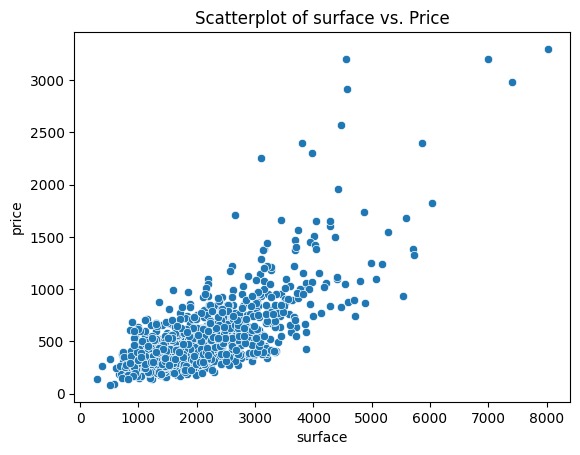

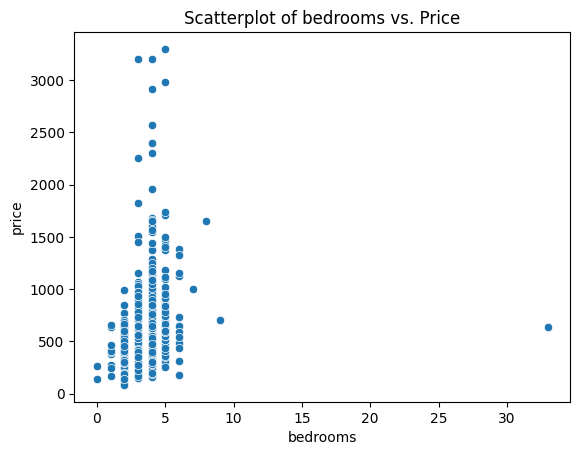

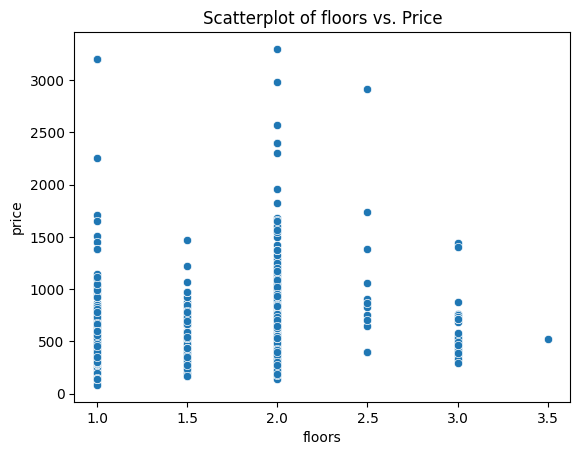

In [180]:
features = ['surface', 'bedrooms', 'floors']

for feature in features:
    sns.scatterplot(data=flats, x=feature, y='price')
    plt.title(f'Scatterplot of {feature} vs. Price')
    plt.show()


👉 It seems that `surface` is a stronger indicator of price than the number of bedrooms or floors. In statistics, we say that `price` is more **correlated** with `surface` than with other features. 

👉 Let's double-check this by running [`pandas.DataFrame.corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) below, which computes correlation coefficients between each pair of columns of the DataFrame. 

<i> <u>Remarkable values:</u></i>
* 1 means that the two columns are perfectly correlated 📈 
* -1 means that the two columns are perfectly inversely correlated 📉 
* 0 means that the two columns are not *linearly* correlated 😐
    
<details>
    <summary><i>Why do we use the correlation coefficient and not the covariance coefficient?</i></summary>

✅ <u>Similarities</u>:
    
- 📈 Positive correlations and positive covariances between two variables X and Y mean the same thing: when X increases, Y increases, and vice-versa.
- 📉 Negative correlations and negative covariances between two variables X and Y mean the same thing: when X increases, Y decreases, and vice-versa.
- 🤔 A null correlation and a null covariance between two variables X and Y mean the same thing: 
    - They are _not linearly correlated_ in the sense that there would exist two real numbers $a$ and $b$  such that $ Y = aX + b$ 
    - However, they could still have a different type of relation such as $Y = X^{2}$ (quadratic relation), $Y = e^{X}$ (exponential relation), $Y = ln(X)$ (logarithmic relation), $Y = sin(\sqrt{1+X^7})$ (super weird relation), etc.

❗️<u>Main differences</u>:

- 😖 The covariance between two variables X and Y can be either infinitely positive or infinitely negative: $ cov(X, Y) \in ( - \infty ; + \infty ) $
    Example: if $ cov (X, Y) = 10 $ and $ cov (X, Z) = 30 $, can you say that X and Z are "more correlated"? _No_, because you cannot compare apples, oranges, and bananas.

    🧑🏻‍🏫 How to solve this problem? Consider the correlation instead, often denoted by the Greek Letter $\rho$ (pronounce "rhô")

👉 <u>Consequence</u>:

- You can view the correlation as a _standardized covariance_, we simply divide the covariance by both the standard deviation of $X$ and the standard deviation of $Y$    
$$ \large  \rho(X,Y) = \frac{cov(X,Y)}{\sigma_X \sigma_Y} \in [0;1]$$

Continuing our example: suppose now that $ \rho(X, Y) = 0.80 $ and $ \rho(X, Z) = 0.15 $, would you still want to say that X and Z are more correlated? No; in fact, X and Y are more correlated than X and Z!
</details>

In [181]:
correlation_matrix = flats.corr()

surface_price_correlation = correlation_matrix['surface']['price']
print(f"Correlation between 'surface' and 'price': {surface_price_correlation}")


Correlation between 'surface' and 'price': 0.7327903613275829


🎨 For a quicker glimpse of this matrix, you can use a **heatmap** from [`seaborn.heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

<details>
    <summary><i>Additional tips to display a nicer correlation matrix</i></summary>

- `cmap`: **Seaborn** being a visualization library built on top of **Matplotlib**, you can use the argument [`cmap`](https://matplotlib.org/stable/tutorials/colors/colormaps.html), which stands for _color map_
- `annot`: to read the correlations even faster, you can show the correlation coefficients directly on the colored heatmap
- `annot_kws`: you can customize how the correlation coefficients appear
</details>

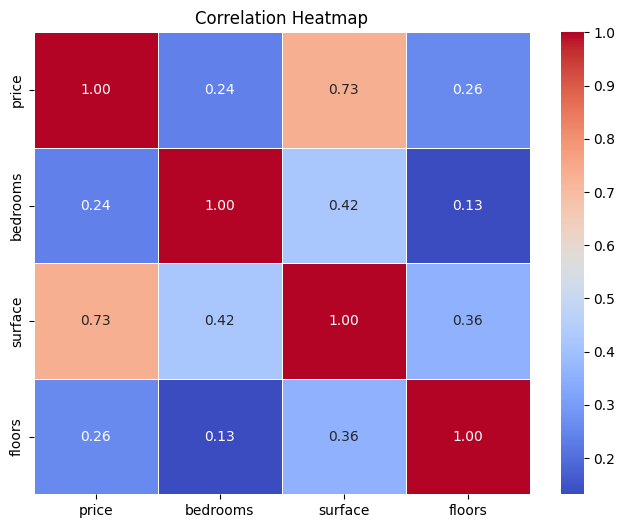

In [182]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


**🧪 Test your code!**

In [183]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'flats',
    shape=flats.shape,
    columns=flats.columns
)

result.write()
print(result.check())



============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/reecepalmer/.pyenv/versions/3.10.6/envs/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/reecepalmer/Code/RPalmr/03-Maths/01-Algebra-Calculus/data-real-estate-advanced-estimator/tests
plugins: asyncio-0.19.0, dash-2.14.0, typeguard-4.1.5, anyio-3.6.2, hydra-core-1.3.2
asyncio: mode=strict
collecting ... collected 2 items

test_flats.py::TestFlats::test_columns PASSED                            [ 50%]
test_flats.py::TestFlats::test_shape PASSED                              [100%]

============================== 2 passed in 0.25s ===============================


💯 You can commit your code:

git add tests/flats.pickle

git commit -m 'Completed flats step'

git push origin master



## (2) Estimator with 1 Feature

Let's try to build a statistical estimator of **price** as a function of only one feature: the **surface**.

🎯 Let's try to fit a **linear regression** between the two variables.

Practically speaking, we want to choose the best parameters $\hat{\boldsymbol \theta}$ = (`slope`, `intercept`) such that the `predicted price = slope * surface + intercept` is as close as possible to the `price` in terms of Mean Squared Error (MSE).

📅 During the next weeks, we will discover and study different models (Linear Regression, KNN, Logistic Regression, Neural Networks, etc.). 

👉 An important part of your job is to choose the right model and optimize the parameters to make the best predictions.

### (2.1) Visual Approach

❓Implement the function `plot_line(slope, intercept)`

When given the `slope` and `intercept` arguments, this function creates an array `predicted_price` and plots that array on top of the original (scattered) data.

When you are done with coding the function, play with different values of `(slope, intercept)` until you find a “good linear approximation” of the data. Can you find the best fit?

Visual guideline:

<img src="https://wagon-public-datasets.s3.amazonaws.com/03-Maths/01-Algebra-Calculus/line_of_best_fit.png" width=400>

In [184]:
def plot_line(data, slope, intercept):
    x = data['surface'].values

    y_pred = slope * x + intercept

    sns.scatterplot(x="surface", y="price", data=data, label='Original Data', color='blue', marker='o')

    plt.plot(x, y_pred, label='Predicted Line', color='red')

    plt.xlabel('Surface')
    plt.ylabel('Price')

    plt.legend()

    plt.show()

x = flats['surface'].values
y = flats['price'].values

x_mean = np.mean(x)
y_mean = np.mean(y)

m = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)
b = y_mean - m * x_mean


Test your function by running the cell below, then change the values to see if you can approximate a good line of best fit!

*Hint: you can run `plot_line()` multiple times in the same cell to get several lines on the same scatterplot* 😉

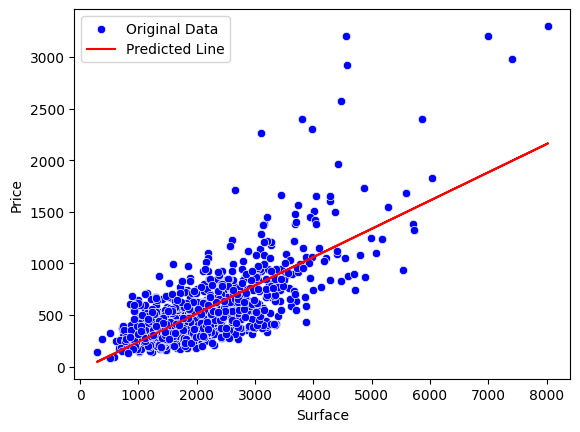

In [185]:
sns.scatterplot(x="surface", y="price", data=flats)
plot_line(flats, m, b)


😅 Not so easy (and not very “scientific”), right?

### (2.2) Computational Approach

🔥 To make sure that our estimator line is the best possible one, we need to compute the **Mean Squared Error** between the **real prices** and the **predicted prices**!

👉 Remember that:
- For each apartment, `predicted_price = slope * surface + intercept`
- Both the **vector of real prices** and the **vector of predicted prices** are of shape $ (1000, 1)$

#### (2.2.1) Squared Errors

<u><b>Step 1</b></u>

❓For each row (_i.e. flat_), we should evaluate the `squared_error = (price - predicted_price)**2`❓

In [186]:
def compute_squared_errors(slope, intercept, surfaces, prices):
    """
    TODO: return an array containing the squared errors between
    all real prices from the dataset and the predicted prices
    """
    squared_errors = []

    for surface, price in zip(surfaces, prices):
        predicted_price = slope * surface + intercept

        squared_error = (price - predicted_price) ** 2

        squared_errors.append(squared_error)

    squared_errors = np.array(squared_errors)

    return squared_errors


💡 A general principle in Data Science/Modeling is that $ \large error = f(\boldsymbol y, \hat{\boldsymbol y})$ where:

- $ \large \boldsymbol y $ is the real value
- $ \large \hat{\boldsymbol y} $ the predicted valute
- $ \large f$ is often called a **Loss Function** or a **Cost Function** 
    - 📆 See `Machine Learning I > Model Tuning`

#### (2.2.2) Mean Squared Errors (MSE)

<u><b>Step 2</b></u>

❓ Create the `mse` function which should return the mean of the array returned by the `squared_errors` function. ❓

In [187]:
def compute_mse(slope, intercept, surfaces, prices):
    '''TODO: Return the mean of the array contained in squared_errors as a float.'''
    squared_errors = compute_squared_errors(slope, intercept, surfaces, prices)

    mse = squared_errors.mean()

    return mse


👉 In section _(2.1) Visual approach_, you visually tried to estimate the "best line", which consists in finding the best pair `(slope, intercept)`. 

❓Using this "best pair", compute the MSE of your estimator. ❓

In [188]:
best_slope = 2.0
best_intercept = 5.0

best_mse = compute_mse(best_slope, best_intercept, surfaces, prices)

print("Mean Squared Error with Best Pair (slope, intercept):", best_mse)


Mean Squared Error with Best Pair (slope, intercept): 16444856.85981891


### (2.3) Finding the Best Parameters

👉 Keep playing with different values for `slope` and `intercept` and try to get the best fit by hand!  Notice how hard it is to optimize both parameters at the same time.

👇 Follow the steps below to get an idea of one potential approach:

#### (2.3.1) Finding the Best Slope

<b><i><u> Step 1 :</u></i></b>

Start by fixing an  `initial_intercept` with your best estimate, then find a slope that approximately minimizes the function  `mse = f(slope)`

In [189]:
initial_intercept = 5.0

slope_values = np.arange(0.1, 5.0, 0.1)

best_slope = None
best_mse = float('inf')

for slope in slope_values:
    mse = compute_mse(slope, initial_intercept, surfaces, prices)

    if mse < best_mse:
        best_slope = slope
        best_mse = mse

print("Best Slope:", best_slope)
print("Corresponding MSE:", best_mse)


Best Slope: 0.30000000000000004
Corresponding MSE: 67998.25532090703


In [190]:
optimal_slope = 2.5

num_slopes = 100
min_slope = 2.0
max_slope = 3.0

slopes = np.linspace(min_slope, max_slope, num_slopes)

print("Slope Values:")
print(slopes)


Slope Values:
[2.         2.01010101 2.02020202 2.03030303 2.04040404 2.05050505
 2.06060606 2.07070707 2.08080808 2.09090909 2.1010101  2.11111111
 2.12121212 2.13131313 2.14141414 2.15151515 2.16161616 2.17171717
 2.18181818 2.19191919 2.2020202  2.21212121 2.22222222 2.23232323
 2.24242424 2.25252525 2.26262626 2.27272727 2.28282828 2.29292929
 2.3030303  2.31313131 2.32323232 2.33333333 2.34343434 2.35353535
 2.36363636 2.37373737 2.38383838 2.39393939 2.4040404  2.41414141
 2.42424242 2.43434343 2.44444444 2.45454545 2.46464646 2.47474747
 2.48484848 2.49494949 2.50505051 2.51515152 2.52525253 2.53535354
 2.54545455 2.55555556 2.56565657 2.57575758 2.58585859 2.5959596
 2.60606061 2.61616162 2.62626263 2.63636364 2.64646465 2.65656566
 2.66666667 2.67676768 2.68686869 2.6969697  2.70707071 2.71717172
 2.72727273 2.73737374 2.74747475 2.75757576 2.76767677 2.77777778
 2.78787879 2.7979798  2.80808081 2.81818182 2.82828283 2.83838384
 2.84848485 2.85858586 2.86868687 2.87878788 2.88

In [191]:
slopes = np.linspace(2.0, 3.0, 100)

mse_list = []

for slope in slopes:
    mse = compute_mse(slope, initial_intercept, surfaces, prices)
    mse_list.append(mse)

print("MSEs for each slope value:")
print(mse_list)


MSEs for each slope value:
[16444856.85981891, 16635509.772244265, 16827265.40616601, 17020123.76158412, 17214084.838498615, 17409148.636909492, 17605315.156816743, 17802584.398220375, 18000956.361120377, 18200431.045516755, 18401008.451409522, 18602688.57879866, 18805471.427684173, 19009356.99806608, 19214345.28994435, 19420436.303318992, 19627630.038190033, 19835926.494557433, 20045325.67242122, 20255827.571781386, 20467432.192637924, 20680139.53499084, 20893949.59884014, 21108862.384185813, 21324877.891027868, 21541996.119366303, 21760217.069201108, 21979540.740532298, 22199967.133359864, 22421496.2476838, 22644128.083504125, 22867862.640820824, 23092699.919633895, 23318639.919943355, 23545682.641749185, 23773828.0850514, 24003076.249849983, 24233427.13614495, 24464880.743936297, 24697437.073224016, 24931096.12400811, 25165857.896288592, 25401722.390065446, 25638689.605338678, 25876759.542108294, 26115932.200374275, 26356207.58013664, 26597585.681395393, 26840066.504150514, 27083650

❓Plot MSEs vs. slopes. Do you see a minimum❓

🙃 If not, try another range of slopes!

In [192]:
pass


❓Compute the minimum value of MSE for your `initial_intercept`, and the corresponding `slope_best` value❓
<br>
<details>
    <summary><i>Hint</i></summary>
    
Here you can use Python's built-in `.min()` function, as well as the `List.index()` method
    
</details>

In [193]:
min_mse = min(mse_list)
slope_best = slopes[mse_list.index(min_mse)]

print("Minimum MSE:", min_mse)
print("Corresponding Best Slope:", slope_best)


Minimum MSE: 16444856.85981891
Corresponding Best Slope: 2.0


#### (2.3.2) Finding the Best Intercept

<b><i><u> Step 2 :</u></i></b>

🔨 Now, let's fix the slope to that `slope_best` value, then re-use the previous approach to find "the" `intercept_best`.

In [194]:
optimal_intercept = 20.0
intercept_range = 10

min_intercept = optimal_intercept - (intercept_range / 2)
max_intercept = optimal_intercept + (intercept_range / 2)

num_intercepts = 100
intercepts = np.linspace(min_intercept, max_intercept, num_intercepts)

print("Intercept Values:")
print(intercepts)


Intercept Values:
[15.         15.1010101  15.2020202  15.3030303  15.4040404  15.50505051
 15.60606061 15.70707071 15.80808081 15.90909091 16.01010101 16.11111111
 16.21212121 16.31313131 16.41414141 16.51515152 16.61616162 16.71717172
 16.81818182 16.91919192 17.02020202 17.12121212 17.22222222 17.32323232
 17.42424242 17.52525253 17.62626263 17.72727273 17.82828283 17.92929293
 18.03030303 18.13131313 18.23232323 18.33333333 18.43434343 18.53535354
 18.63636364 18.73737374 18.83838384 18.93939394 19.04040404 19.14141414
 19.24242424 19.34343434 19.44444444 19.54545455 19.64646465 19.74747475
 19.84848485 19.94949495 20.05050505 20.15151515 20.25252525 20.35353535
 20.45454545 20.55555556 20.65656566 20.75757576 20.85858586 20.95959596
 21.06060606 21.16161616 21.26262626 21.36363636 21.46464646 21.56565657
 21.66666667 21.76767677 21.86868687 21.96969697 22.07070707 22.17171717
 22.27272727 22.37373737 22.47474747 22.57575758 22.67676768 22.77777778
 22.87878788 22.97979798 23.08080

In [195]:
intercepts = np.linspace(optimal_intercept - 5, optimal_intercept + 5, 100)

mse_list = []

for intercept in intercepts:
    mse = compute_mse(slope_best, intercept, surfaces, prices)
    mse_list.append(mse)

print("MSEs for each intercept value:")
print(mse_list)


MSEs for each intercept value:
[16518947.243478907, 16519696.651496693, 16520446.079920564, 16521195.528750515, 16521944.997986546, 16522694.487628656, 16523443.99767685, 16524193.528131122, 16524943.078991478, 16525692.650257915, 16526442.24193043, 16527191.854009034, 16527941.48649371, 16528691.13938447, 16529440.81268131, 16530190.506384235, 16530940.220493235, 16531689.95500832, 16532439.709929485, 16533189.485256732, 16533939.280990059, 16534689.097129468, 16535438.93367496, 16536188.790626526, 16536938.667984176, 16537688.565747911, 16538438.483917722, 16539188.422493618, 16539938.381475592, 16540688.360863652, 16541438.360657787, 16542188.380858002, 16542938.421464305, 16543688.482476685, 16544438.563895147, 16545188.665719688, 16545938.787950313, 16546688.930587018, 16547439.093629805, 16548189.277078666, 16548939.480933614, 16549689.705194645, 16550439.949861752, 16551190.214934943, 16551940.500414215, 16552690.80629957, 16553441.132591002, 16554191.479288517, 16554941.8463921

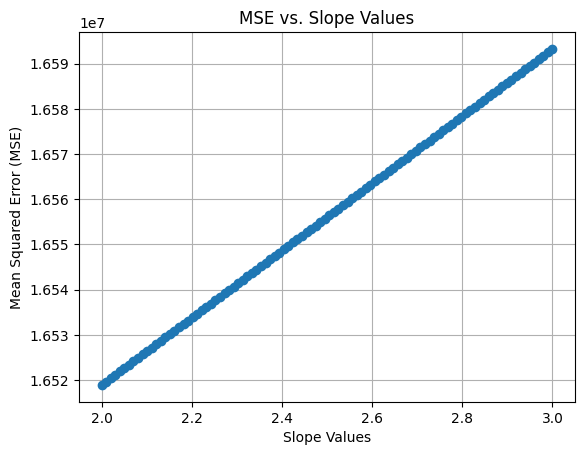

In [196]:
plt.plot(slopes, mse_list, marker='o', linestyle='-')
plt.xlabel('Slope Values')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Slope Values')
plt.grid(True)

plt.show()


❓Compute `mse_min`, the minimum value of MSEs when slope is equal to `slope_best`, and store the corresponding best intercept as `intercept_best`❓


In [197]:
mse_min = None
intercept_best = None


In [198]:
mse_min = min(mse_list)
intercept_best = intercepts[mse_list.index(mse_min)]

print("Minimum MSE with Best Slope (slope_best):", mse_min)
print("Corresponding Best Intercept (intercept_best):", intercept_best)


Minimum MSE with Best Slope (slope_best): 16518947.243478907
Corresponding Best Intercept (intercept_best): 15.0


**🧪 Test your code!**

In [199]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'univariate',
    mse_min=mse_min,
    slope_best=slope_best,
    intercept_best=intercept_best
)

result.write()
print(result.check())



============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/reecepalmer/.pyenv/versions/3.10.6/envs/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/reecepalmer/Code/RPalmr/03-Maths/01-Algebra-Calculus/data-real-estate-advanced-estimator/tests
plugins: asyncio-0.19.0, dash-2.14.0, typeguard-4.1.5, anyio-3.6.2, hydra-core-1.3.2
asyncio: mode=strict
collecting ... collected 3 items

test_univariate.py::TestUnivariate::test_best_intercept PASSED           [ 33%]
test_univariate.py::TestUnivariate::test_best_slope FAILED               [ 66%]
test_univariate.py::TestUnivariate::test_mse FAILED                      [100%]

=================================== FAILURES ===================================
________________________ TestUnivariate.test_best_slope ________________________

self = <tests.test_univariate.TestUnivariate testMethod=test_best_slope>

    def test_best_slope(self):
   

🎉 **Great job**! By adding a non-zero intercept parameter, we were able to reduce the MSE even more (feel free to plot the regression line on your scatter plot to visually confirm the approximate fit).

❓However, what guarantees that these (`intercept_best`, `slope_best`) parameters are really the best ones? 

<details>
    <summary>👀 Explanations</summary>

We could maybe find an even better slope value by repeating step ①, this time fixing the intercept at `intercept_best`, and then repeating step ② with the new slope to adjust the intercept again.

To find the global minimum of a 2-parameter function `rmse = f(slope, intercept)`, we may have to repeat steps ① and ② indefinitely until values converge towards absolute minima - with no guarantee of success.

<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/decision-science/real-estate-minimizer.png'>

💪 You've just discovered one of the most fundamental aspects of Machine Learning: **the iterative process of finding minima**.

👉 As you might guess, in the world of Data Science, algorithms have been developed to automate and optimize such processes. In the next few weeks, you will discover the power of other algorithms such as **Gradient Descent**, and Python libraries such as `Statsmodels` that perform this iterative process for you.
</details>

👉 Run the cells below if you are curious and want to find the real best slope and intercept for this dataset, computed using **Gradient Descent** (📆 covered in **Machine Learning I > Under The Hood**).

<AxesSubplot:xlabel='surface', ylabel='price'>

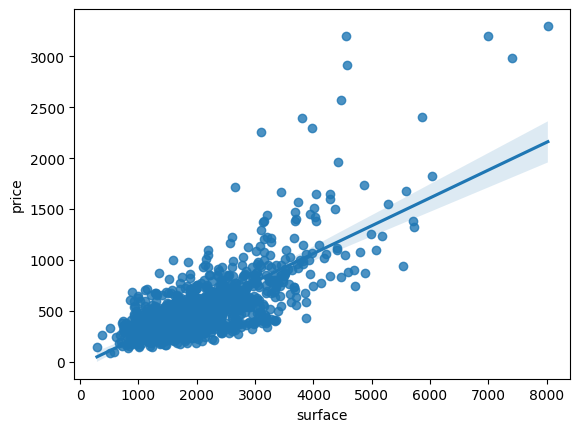

In [200]:
# Try this out (Seaborn visual solution)
sns.regplot(data=flats, x='surface', y='price')


In [201]:
# Try this out (statsmodels, exact solution)!
import statsmodels.formula.api as smf

regression = smf.ols(formula= 'price ~ surface', data=flats).fit()

print("intercept_best", regression.params['Intercept'])
print("slope_best", regression.params['surface'])
print('mse_best: ', np.mean(regression.resid**2))


intercept_best -33.3083359853561
slope_best 0.27369043218689093
mse_best:  58515.1239094964


❓Let's go back to our initial question: what is your new prediction for the 5th flat below? How does it compare with your initial prediction based on only 4 flats?

- `surface`: 3000 $ft^2$
- `bedrooms`: 5 
- `floors`: 1

In [202]:
# compute predicted price (Remember that the real price is 750,000$)
pass  # YOUR CODE HERE


☝️ It's better than our initial deterministic estimator based on only 4 flats, but obviously we are missing the information provided by the number of bedrooms and floors in this prediction!

## (3) Estimator with _All_ Features (`surface`, `bedrooms`, `floors`)?

💡 A linear regression with three features (**Multivariate Linear Regression**) works the same way as with one feature, but instead of determining only 2 parameters to minimize the RMSE (`intercept` and `slope`), we will need to find 4 parameters: $\hat{\boldsymbol \theta}$ = (`intercept`, `slope_surface`, `slope_bedrooms`, `slope_floors`).

🗓 There will be a lecture fully dedicated to **Multivariate Linear Regression** in the **Decision Science** module.

🗓 The same **Gradient Descent** iterative method is applicable, and you will code it yourself by hand later in the bootcamp.

👉 Meanwhile, feel free to run the cell below to see the final result of this multivariate regression:

In [203]:
# Find the four regression coefficients by running this cell
regression = smf.ols(formula= 'price ~ surface + bedrooms + floors', data=flats).fit()
regression.params


Intercept    18.154854
surface       0.286953
bedrooms    -21.623564
floors       -3.811868
dtype: float64

🎉 Now that we have found the best parameters $\boldsymbol {\hat \theta}= \begin{bmatrix}
     \theta_0 \\
     \theta_1 \\
    \theta_2 \\
     \theta_3 \\
\end{bmatrix}_{4 \times 1} = 
\begin{bmatrix}
     \theta_{intercept} \\
     \theta_{surface}\\
    \theta_{bedrooms} \\
     \theta_{floors}
\end{bmatrix}_{4 \times 1} = 
\begin{bmatrix}
    18.154854 \\
    0.286953 \\
    -21.623564 \\
    -3.811868
\end{bmatrix}_{4 \times 1}
$, 

we can predict the price of the new flat with:
* $3000 ft^2$
* $5$ bedrooms
* located on the $1st$ floor

$$ \hat{y_5} = \theta_0 + \theta_1 \times 3000 + \theta_2 \times 5 + \theta_3 \times 1 $$

In [204]:
# Compute the newly predicted price for the 5th flat? Is this prediction better?
pass  # YOUR CODE HERE


## (4) Concluding Remarks on Linear Algebra 🧠

This **optimization problem** can be summarized as follows

- We need to find a vector of parameters $\hat{\boldsymbol \theta} = \begin{bmatrix}
     \theta_{intercept} \\
     \theta_{surface}\\
    \theta_{bedrooms} \\
     \theta_{floors}
\end{bmatrix}_{4 \times 1}$ 

- That minimizes an error $e = \left\|\boldsymbol X\cdot \hat{\boldsymbol \theta} - \boldsymbol y  \right\|^2$

- For a given matrix of features $\boldsymbol X$ [constant, surfaces, floors, bedrooms]  $\begin{bmatrix}
    1 & 620 & 1 & 1 \\
    1 & 3280 & 4 & 2 \\
    ... \\
    1 & 1900 & 2 & 2 \\
    1 & 1320 & 3 & 3
   \end{bmatrix}_{n \times 4}
$

- and a vector of observations $\boldsymbol y  = \begin{bmatrix}
           y_{1} \\
           y_{2} \\
           \vdots \\
           y_{1000}
         \end{bmatrix}$ (prices)

Such a $\large \hat{\theta}$ is reached when the "derivatives" of $\boldsymbol e$, that is $ \large 2 \boldsymbol X^T\cdot (\boldsymbol X \cdot \hat{\theta}−\boldsymbol y )$, equal zero (👉 proof during the Decision Science module). 
    
In other words, we need to solve the linear system $\large (\boldsymbol X^T\cdot \boldsymbol X)\cdot \hat{\boldsymbol \theta}=\boldsymbol X^T \cdot \boldsymbol y $. 
    
This linear system has a unique solution provided that no column of $\boldsymbol X$ can be expressed as a linear combination of the others: in that case, $ \large (\boldsymbol X^T \cdot \boldsymbol X)^{-1}$ is invertible and the minimum is reached when $\large \hat{\boldsymbol \theta} = (\boldsymbol X^T\cdot \boldsymbol X)^{-1} \cdot \boldsymbol X^T \cdot \boldsymbol y $. Notice how $\boldsymbol X$ does not need to be squared anymore compared to the first challenge 💪.

💥 However, keep in mind that **inverting matrices is computationally complex**. That is why other methods have been developed to find the minimum of a function, such as **Gradient Descent**.
    
📚 Read more on [Stats.StackExchange](https://stats.stackexchange.com/a/278779) if you are interested!
</details>

🏁 Congratulations! 

💾 Don't forget to `git add/commit/push` your notebook!